In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_3c"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

MCMC_SIZE = 10
BATCH_SIZE = 500
NUM_EPOCHS = 250
LEARNING_RATE = 5 * 1e-4
CUDA = torch.cuda.is_available()
PATH = '../neurips/ag-10runs/'
DEVICE = torch.device('cuda:1')

Train_Params = (NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D, MCMC_SIZE)

In [3]:
from local_enc import *
from global_oneshot import *
from global_enc_v1 import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE, Reparameterized)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)

if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)
    oneshot_eta.cuda().to(DEVICE)
models = (oneshot_eta, enc_eta, enc_z)

In [4]:
enc_z_baseline = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta_baseline = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)

if CUDA:
    enc_z_baseline.cuda().to(DEVICE)
    oneshot_eta_baseline.cuda().to(DEVICE)
models_baseline = (oneshot_eta_baseline, enc_z_baseline)

In [49]:
i = 4
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE, Reparameterized)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)

if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)
    oneshot_eta.cuda().to(DEVICE)
models = (oneshot_eta, enc_eta, enc_z)
enc_z.load_state_dict(torch.load(PATH + "enc-z-ag-10runs-%dround" % i))
enc_eta.load_state_dict(torch.load(PATH + "enc-eta-ag-10runs-%dround" % i))
oneshot_eta.load_state_dict(torch.load(PATH + "oneshot-eta-ag-10runs-%dround" % i))

In [50]:
j = 5
enc_z_baseline = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
oneshot_eta_baseline = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)

if CUDA:
    enc_z_baseline.cuda().to(DEVICE)
    oneshot_eta_baseline.cuda().to(DEVICE)
enc_z_baseline.load_state_dict(torch.load(PATH + "enc-z-ag-10runs-%dround" % j))
oneshot_eta_baseline.load_state_dict(torch.load(PATH + "oneshot-eta-ag-10runs-%dround" % j))

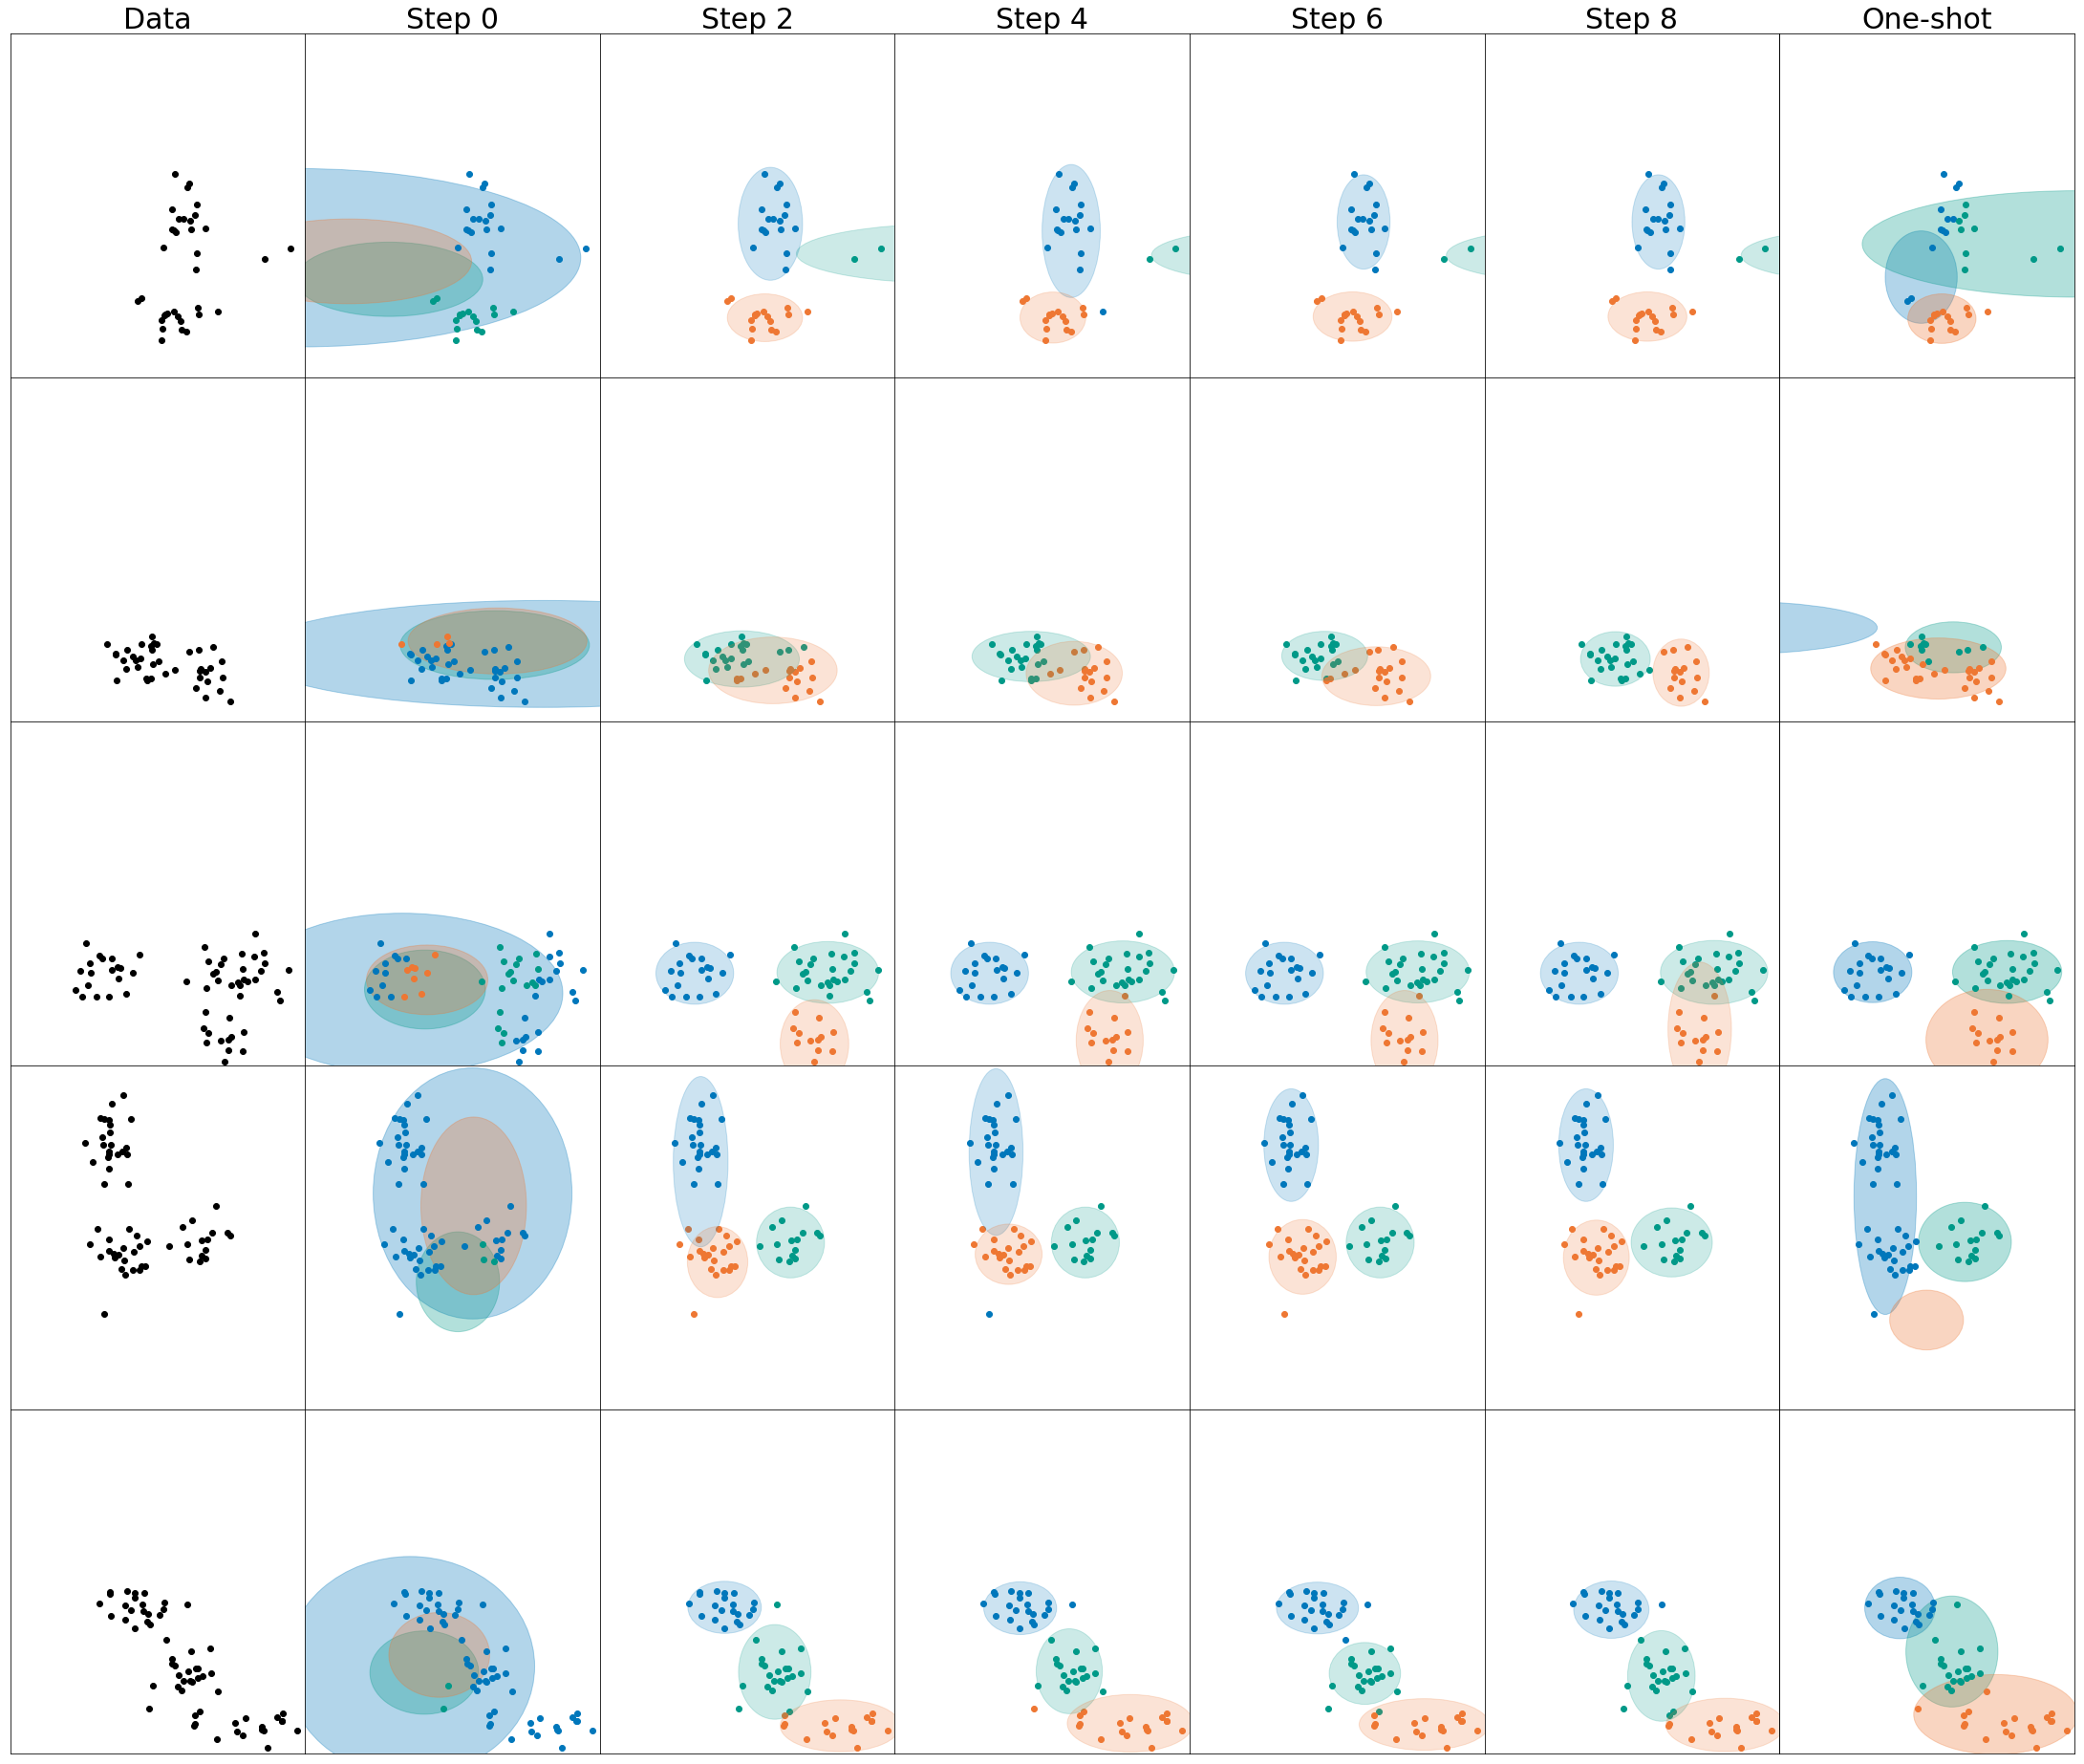

In [55]:
MAX_MCMC_STEPS = 8 ## 12 is maximum mcmc steps
SAMPLE_SIZE = 1
BATCH_SIZE = 5
Vis_Interval = 2
##
xl = 8
xr = 8
yl = 6
yr = 17
##
colors = ['#0077BB', '#009988', '#EE7733']
gs = gridspec.GridSpec(BATCH_SIZE, 3+int(MAX_MCMC_STEPS / Vis_Interval))
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(30,25))

indices = torch.arange(NUM_DATASETS)
step = 67
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
obs = Data[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    obs =obs.cuda().to(DEVICE)
    
xs = obs[0].cpu().data.numpy()    
for b in range(BATCH_SIZE):
    xb = xs[b]
    ax = fig.add_subplot(gs[b, 0])
    ax.scatter(xb[:, 0], xb[:, 1], c='k')
    ax.set_ylim([-yl, yr])
    ax.set_xlim([-xl, xr])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title('Data', fontsize=30)
q_eta, p_eta, q_nu = oneshot_eta(obs, K, D)
obs_mu = q_eta['means'].value
obs_tau = q_eta['precisions'].value
q_z, p_z = enc_z.forward(obs, obs_tau, obs_mu, N, K, SAMPLE_SIZE, BATCH_SIZE)
state = q_z['zs'].value ## S * B * N * K
E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()

for b in range(BATCH_SIZE):
    ax = fig.add_subplot(gs[b, 1])
    xb = xs[b]
    zb = E_z[b]
    mu = E_mu[b].reshape(K, D)
    sigma2 = 1. / E_tau[b]
    assignments = zb.argmax(-1)
    for k in range(K):
        cov_k = np.diag(sigma2[k])
        xk = xb[np.where(assignments == k)]
        ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], zorder=3)
        plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.3, color=colors[k])
    ax.set_ylim([-yl, yr])
    ax.set_xlim([-xl, xr])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title("Step 0", fontsize=30)
## =======================================
q_eta, p_eta, q_nu = oneshot_eta_baseline(obs, K, D)
obs_mu = q_eta['means'].value
obs_tau = q_eta['precisions'].value
q_z, p_z = enc_z.forward(obs, obs_tau, obs_mu, N, K, SAMPLE_SIZE, BATCH_SIZE)
state = q_z['zs'].value ## S * B * N * K
E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()

for b in range(BATCH_SIZE):
    ax = fig.add_subplot(gs[b, -1])
    xb = xs[b]
    zb = E_z[b]
    mu = E_mu[b].reshape(K, D)
    sigma2 = 1. / E_tau[b]
    assignments = zb.argmax(-1)
    for k in range(K):
        cov_k = np.diag(sigma2[k])
        xk = xb[np.where(assignments == k)]
        ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], zorder=3)
        plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.3, color=colors[k])
    ax.set_ylim([-yl, yr])
    ax.set_xlim([-xl, xr])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title("One-shot", fontsize=30)
        
for m in range(MAX_MCMC_STEPS):
    q_eta, p_eta, q_nu = enc_eta(obs, state, K, D)
    obs_tau, obs_mu, log_w_eta_f, log_w_eta_b  = Incremental_eta(q_eta, p_eta, obs, state, K, D, obs_tau, obs_mu)
    symkl_detailed_balance_eta, eubo_p_q_eta, w_sym_eta, w_f_eta = detailed_balances(log_w_eta_f, log_w_eta_b)
    obs_mu, obs_tau = resample_eta(obs_mu, obs_tau, w_f_eta, idw_flag=True) ## resample eta
    q_z, p_z = enc_z.forward(obs, obs_tau, obs_mu, N, K, SAMPLE_SIZE, BATCH_SIZE)
    state, log_w_z_f, log_w_z_b = Incremental_z(q_z, p_z, obs, obs_tau, obs_mu, K, D, state)
    if (m+1) % Vis_Interval == 0:
        E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
        E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
        E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
        for b in range(BATCH_SIZE):
            ax = fig.add_subplot(gs[b, 1+int((m+1)/Vis_Interval)])
            xb = xs[b]
            zb = E_z[b]
            mu = E_mu[b].reshape(K, D)
            sigma2 = 1. / E_tau[b]
            assignments = zb.argmax(-1)
            for k in range(K):
                cov_k = np.diag(sigma2[k])
                xk = xb[np.where(assignments == k)]
                ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
                plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
            ax.set_ylim([-yl, yr])
            ax.set_xlim([-xl, xr])
            ax.set_xticks([])
            ax.set_yticks([])
            if b == 0:
                ax.set_title('Step %d' % (m+1), fontsize=30)
plt.savefig('../results/sample%d-gmm.svg' % step)